In [11]:
import os
import sys
sys.path.append(os.path.abspath('../torch_utils'))
sys.path.append(os.path.abspath('../training/'))

import os
import sys 
import numpy as np
import scipy.signal
import scipy.optimize
import torch

import torch.nn.functional as F
import torch.nn as nn
from typing import Optional

from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesAtlas,
    TexturesUV
)
from pytorch3d.renderer.blending import (
    hard_rgb_blend,
    BlendParams
)
from pytorch3d.renderer.utils import TensorProperties
from pytorch3d.common import Device
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.ops import interpolate_face_attributes


In [66]:

class HardAlbedoShader(nn.Module):
    """
    Per pixel lighting - the lighting model is applied using the interpolated
    coordinates and normals for each pixel. The blending function hard assigns
    the color of the closest face for each pixel.

    To use the default values, simply initialize the shader with the desired
    device e.g.

    .. code-block::

        shader = HardPhongShader(device=torch.device("cuda:0"))
    """

    def __init__(
        self,
        device: "cpu",
        cameras: Optional[TensorProperties] = None,
        lights: Optional[TensorProperties] = None,
        materials: Optional[Materials] = None,
        blend_params: Optional[BlendParams] = None,
    ) -> None:
        super().__init__()
        self.lights = lights if lights is not None else PointLights(device=device)
        self.materials = (
            materials if materials is not None else Materials(device=device)
        )
        self.cameras = cameras
        self.blend_params = blend_params if blend_params is not None else BlendParams()

    # pyre-fixme[14]: `to` overrides method defined in `Module` inconsistently.
    def to(self, device: Device):
        # Manually move to device modules which are not subclasses of nn.Module
        cameras = self.cameras
        if cameras is not None:
            self.cameras = cameras.to(device)
        self.materials = self.materials.to(device)
        self.lights = self.lights.to(device)
        return self


    def forward(self, fragments: Fragments, meshes: Meshes, **kwargs) -> torch.Tensor:
        cameras = kwargs.get("cameras", self.cameras)
        if cameras is None:
            msg = "Cameras must be specified either at initialization \
                or in the forward pass of HardAlbedoShader"
            raise ValueError(msg)

        texels = meshes.sample_textures(fragments)
        lights = kwargs.get("lights", self.lights)
        materials = kwargs.get("materials", self.materials)
        blend_params = kwargs.get("blend_params", self.blend_params)
        colors = texels
        images = hard_rgb_blend(colors, fragments, blend_params)
        return images

#----------------------------------------------------------------------------
class UVInput(torch.nn.Module):
    def __init__(self,
        w_dim,          # Intermediate latent (W) dimensionality.
        channels,       # Number of output channels.
        size,           # Output spatial size: int or [width, height].
        sampling_rate,  # Output sampling rate.
        bandwidth,      # Output bandwidth.
    ):
        super().__init__()
        self.w_dim = w_dim
        self.channels = channels
        self.size = np.broadcast_to(np.asarray(size), [2])
        self.sampling_rate = sampling_rate
        self.bandwidth = bandwidth

        # Draw random frequencies from uniform 2D disc.
        freqs = torch.randn([self.channels, 2])
        radii = freqs.square().sum(dim=1, keepdim=True).sqrt()
        freqs /= radii * radii.square().exp().pow(0.25)
        freqs *= bandwidth
        phases = torch.rand([self.channels]) - 0.5

        # Setup parameters and buffers.
        self.weight = torch.nn.Parameter(torch.randn([self.channels, self.channels]))
        #self.affine = FullyConnectedLayer(w_dim, 3, weight_init=0, bias_init=[1,0,0])
        self.register_buffer('transform', torch.eye(4, 4)) # User-specified inverse transform wrt. resulting image.
        self.register_buffer('freqs', freqs)
        self.register_buffer('phases', phases)

        self.set_obj("../data/head_template_mesh.obj")
    
    def set_obj(self, filename):
        verts, faces, aux = load_obj(filename)
        verts = verts[None, ...]            # (N, V, 3)
        uvcoords = aux.verts_uvs[None, ...]  # (N, Vt, 2)
        uvfaces = faces.textures_idx[None, ...]  # (N, F, 3)
        faces = faces.verts_idx[None, ...]      # (N, F, 3)
        
        verts = verts - verts.mean(dim=1, keepdim=True)
        verts = verts / verts.abs().max(dim=1, keepdim=True)[0]

        self.register_buffer('verts', verts)
        self.register_buffer('uvcoords', uvcoords)
        self.register_buffer('uvfaces', uvfaces)
        self.register_buffer('faces', faces)


    def forward(self, w):
        # Introduce batch dimension.
        transforms = self.transform.unsqueeze(0) # [batch, row, col]
        freqs = self.freqs.unsqueeze(0) # [batch, channel, xy]
        phases = self.phases.unsqueeze(0) # [batch, channel]

        # Apply learned transformation.
        #t = self.affine(w).float() # t = (dist, elev, azim)
        device = w.device

        R, T = look_at_view_transform(dist=torch.ones(w.shape[0], 1), elev=torch.zeros(w.shape[0], 1), azim=torch.zeros(w.shape[0], 1))
        R = R.to(device)
        T = T.to(device)

        # Transform frequencies.
        T = T + (R @ transforms[:, :3, 3:]).squeeze(2)
        R = R @ transforms[:, :3, :3]

        cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

        grid = F.affine_grid(torch.eye(2,3, device=device).unsqueeze(0), (1, 2, self.size[1], self.size[0]))
        grid[..., 0] = 0.5 * self.size[0] / self.sampling_rate
        grid[..., 1] = 0.5 * self.size[1] / self.sampling_rate
        tex = TexturesUV(grid, self.uvfaces.to(device), self.uvcoords.to(device))

        mesh = Meshes(
                    verts=self.verts.to(device),
                    faces=self.faces.to(device),
                    textures=tex
                )

        raster_settings = RasterizationSettings(
            image_size=(int(self.size[1]), int(self.size[0])), 
            blur_radius=0.0, 
            faces_per_pixel=1, 
        )

        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras, 
                raster_settings=raster_settings
            ),
            shader=HardAlbedoShader(
                device=device, 
                cameras=cameras
            )
        )

        target_images = renderer(mesh, cameras=cameras)[..., :2]

        # Compute Fourier features.
        #print(target_images.shape, freqs.shape)
        #target_images = grid
        x = (target_images.unsqueeze(3) @ freqs.permute(0, 2, 1).unsqueeze(1).unsqueeze(2)).squeeze(3) # [batch, height, width, channel]
        x = x + phases.unsqueeze(1).unsqueeze(2)
        x = torch.sin(x * (np.pi * 2))
        #x = x * amplitudes.unsqueeze(1).unsqueeze(2)

        # Apply trainable mapping.
        weight = self.weight / np.sqrt(self.channels)
        x = x @ weight.t()

        # Ensure correct shape.
        x = x.permute(0, 3, 1, 2) # [batch, channel, height, width]
        #misc.assert_shape(x, [w.shape[0], self.channels, int(self.size[1]), int(self.size[0])])
        return x

    def forward_render_only(self, w):
        # Introduce batch dimension.
        transforms = self.transform.unsqueeze(0) # [batch, row, col]
        freqs = self.freqs.unsqueeze(0) # [batch, channel, xy]
        phases = self.phases.unsqueeze(0) # [batch, channel]

        # Apply learned transformation.
        #t = self.affine(w) # t = (dist, elev, azim)
        device = w.device
        t = torch.ones_like(w)[:, :3].float()
        t[:,0] = 1
        t[:,1] = 0
        t[:,2] = 0
        
        R, T = look_at_view_transform(dist=torch.ones(w.shape[0], 1), elev=torch.zeros(w.shape[0], 1), azim=torch.zeros(w.shape[0], 1))
        R = R.to(device)
        T = T.to(device)

        # Transform frequencies.
        T = T + (R @ transforms[:, :3, 3:]).squeeze(2)
        R = R @ transforms[:, :3, :3]

        cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

        grid = F.affine_grid(torch.eye(2,3, device=device).unsqueeze(0), (1, 2, self.size[1], self.size[0]))
        print(grid.shape)
        #grid[..., 0] = 0.5 * self.size[0] / self.sampling_rate
        #grid[..., 1] = 0.5 * self.size[1] / self.sampling_rate
        tex = TexturesUV(grid, self.uvfaces.to(device), self.uvcoords.to(device))

        mesh = Meshes(
                    verts=self.verts.to(device),
                    faces=self.faces.to(device),
                    textures=tex
                )

        raster_settings = RasterizationSettings(
            image_size=(int(self.size[1]), int(self.size[0])), 
            blur_radius=0.0, 
            faces_per_pixel=1, 
        )

        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras, 
                raster_settings=raster_settings
            ),
            shader=HardAlbedoShader(
                device=device, 
                cameras=cameras
            )
        )

        target_images = renderer(mesh, cameras=cameras)
        x = target_images

        # Ensure correct shape.
        x = x.permute(0, 3, 1, 2) # [batch, channel, height, width]
        #misc.assert_shape(x, [w.shape[0], 3, int(self.size[1]), int(self.size[0])])

        return x

In [67]:
input = UVInput(
            w_dim=512, channels=512, size=512,
            sampling_rate=30, bandwidth=30).to("cuda")

In [68]:
a = input.forward_render_only(torch.randn(1,512, device='cuda'))

torch.Size([1, 512, 512, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


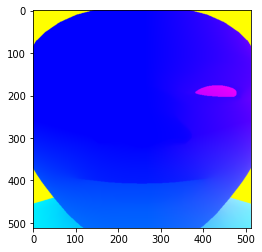

In [69]:
import matplotlib.pyplot as plt
plt.imshow(a.cpu()[0].permute(1,2,0))